In [1]:
# import glob
# import os
import pandas as pd
import altair as alt
import calendar
import datetime
from altair import pipe, limit_rows, to_values

In [2]:
# This code combines the various VPD Crime datasets (separated by neighbourhood and year) into one combined.csv

# # Set the directory where the CSV files are located
# dir_path = "."

# # Get all the CSV files in the directory
# all_files = glob.glob(os.path.join(dir_path, "*.csv"))

# # Combine the CSV files into a single DataFrame
# df = pd.concat((pd.read_csv(f) for f in all_files))

# # Save the combined DataFrame to a new CSV file
# df.to_csv("combined.csv", index=False)

In [3]:
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable('data_server')
# Include an image for each plot since Gradescope only supports displaying plots as images
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

# VPD Crime + CMHC Income Analysis

By: Benjamin Chang, Sandra Radic, and Justin Kung

## Abstract

The project includes analyzing the Vancouver Crime dataset, which contains information on crime types, location, date, and time, as well as demographic data from the Vancouver 2016 census dataset.

## Data Abstraction

The [VPD Crime dataset](https://geodash.vpd.ca/opendata/) contains crime occurrence data that takes place in neighbourhoods patrolled by the Vancouver Police Department. It contains information on crime type, location (hundred block, neighbourhood), date (year, month, day), time (hour, minute, second), and polar coordinates (latitude, longitude) of each occurrence. To supplement our analysis of the crime dataset, we have also sourced neighbourhood median and average income data from the [Canada Mortgage and Housing Corporation dataset](https://www03.cmhc-schl.gc.ca/hmip-pimh/en/TableMapChart/TableMatchingCriteria?GeographyType=MetropolitanMajorArea&GeographyId=2410&CategoryLevel1=Population%2C%20Households%20and%20Housing%20Stock&CategoryLevel2=Household%20Income&ColumnField=HouseholdIncomeRange&RowField=Neighbourhood&SearchTags%5B0%5D.Key=Households&SearchTags%5B0%5D.Value=Number&SearchTags%5B1%5D.Key=Statistics&SearchTags%5B1%5D.Value=AverageAndMedian).

Overall, the data includes: <br>
1. Neighborhood - nominal. Each observation belongs to one neighborhood (one-to-one). Each neighborhood is a label for a specific geographic area in Greater Vancouver.
2. Hundred block - nominal. Each observation belongs to one hundred block (one-to-one). It indicates the block number where a crime was reported.
3. Latitude, Longitude (X, Y) - quantitative. Each observation contains one latitude and one longitude value (one-to-one), which each represent a numerical measurements of geographic coordinates. These variables are continuous and can take on any value within a certain range, with each value indicating a specific location.
4. Date (Year, Month, Day) - nominal. Each observation contains one year, one month, and one day value (one-to-one). These variables have interdependent cardinalities within them, as a year has many months, and a month has many days. However, as observations within the dataset they may be collated into a singular DATE variable which has a one-to-one cardinality with each occurrence. The DATE variable marks the exact day, month, and year that the crime was reported.
5. Hour, Minute, Second - ordinal. Each variable represents a specific point in time (one-to-one). Similarly to the Date variable, these variables have interdependent cardinalities, but can be aggregated and worked with independently of each other.
6. Crime Type (Type) - nominal. Each observation has exactly one 'Type' (one-to-one). The crime type variable is a categorical variable that indicates the type of crime that was reported. Similar to the neighborhood and hundred block variables, this is a nominal variable with no inherent order or ranking. Each observation is simply classified according to a specific crime category.
7. Average Household Income After Taxes - quantitative. Each observation has exactly one average income as the dataset provides it as an aggregate (one-to-one). It is a quantitative variable, however it is static which means that we only have singular values for each neighbourhood - and can not chart or infer temporal information from it. It is a singular value that shows the average household income of each neighbourhood (therefore it will be explored in the multivariate EDA section).
8. Median Household Income After Taxes - quantitative. Similar to the average household income after taxes with regards to cardinality and semantics, but less pertinent to skewing to high values (abnormally high incomes skew the average value), median household income may serve as a more realistic representation of the majority.

In [4]:
# Read in the data
url = 'https://raw.githubusercontent.com/sgskung/crime320/main/combined.csv'
df = pd.read_csv(url)

In [5]:
# Creating necessary variables
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

In [6]:
# Change the max_rows limit of altair because our dataset is 55,000 rows.
t = lambda data: pipe(data, limit_rows(max_rows=60000), to_values)
alt.data_transformers.register('custom', t)
alt.data_transformers.enable('custom')

DataTransformerRegistry.enable('custom')

In [34]:
# Transforming the supplemental income dataset to correspond to each neighbourhood in our analysis.
url2 = 'https://raw.githubusercontent.com/sgskung/crime320/main/incomes.csv'

dfinc = pd.read_csv(url2, header=0, index_col=0)
dfinc = dfinc[0:2]

dfinc['Central Business District'] = dfinc[['Downtown North', 'Downtown Central', 'Downtown']].apply(lambda x: x.mean(), axis=1)
dfinc = dfinc.drop(columns=['Downtown North', 'Downtown Central', 'Downtown'])

dfinc['Strathcona'] = dfinc[['Downtown Eastside/Strathcona']].apply(lambda x: x.mean(), axis=1)
dfinc = dfinc.drop(columns=['Downtown Eastside/Strathcona'])

dfinc['Hastings-Sunrise'] = dfinc[['Hastings/Sunrise/Grandview/Woodlands']].apply(lambda x: x.mean(), axis=1)
dfinc = dfinc.drop(columns=['Hastings/Sunrise/Grandview/Woodlands'])

dfinc['Renfrew-Collingwood'] = dfinc[['Collingwood', 'Renfrew']].apply(lambda x: x.mean(), axis=1)
dfinc = dfinc.drop(columns=['Collingwood', 'Renfrew'])

dfinc['Victoria-Fraserview'] = dfinc[['Fraser View/Killarny']].apply(lambda x: x.mean(), axis=1)
dfinc = dfinc.drop(columns=['Fraser View/Killarny'])

dfinc['Fairview'] = dfinc[['South Granville']].apply(lambda x: x.mean(), axis=1)
dfinc = dfinc.drop(columns=['South Granville'])

# list of columns to keep
keep_cols = ['Central Business District', 'Strathcona', 'Hastings-Sunrise', 'Renfrew-Collingwood', 'Victoria-Fraserview', 'Fairview']

# list of columns to drop
drop_cols = list(set(dfinc.columns) - set(keep_cols))

# drop the columns from the dataframe
dfinc = dfinc.drop(columns=drop_cols)

# round the values to 2 decimal places
dfinc = dfinc.apply(lambda x: x.round(2), axis=1)

dfinc = dfinc.T
dfinc = dfinc.reset_index(names = 'Neighborhood')
dfinc.to_csv('incomes_ab.csv', index=False)

## Exploratory Data Analysis

### Univariate Summaries
We first create univariate summaries of each variable in our dataset. Latitude and Longitude are skipped over as they are all relatively the same (all crimes take place in the Vancouver-Downtown/Vancouver-East geographic space, and neighbourhood/hundred-block serves a more intuitive purpose for our analysis. Furthermore, as most of our variables are nominal, the following univariate summaries will be bar charts, grouped numerical summaries, and line charts for temporal information (year, hour, etc.).

In [8]:
df = df.drop(columns=['X', 'Y'])
df.describe().applymap('{:,.2f}'.format)

,YEAR,MONTH,DAY,HOUR,MINUTE
count,"55,398.00","55,398.00","55,398.00","55,398.00","55,398.00"
mean,"2,020.98",6.40,15.23,11.24,17.59
std,0.83,3.48,8.71,7.57,18.89
min,"2,020.00",1.00,1.00,0.00,0.00
25%,"2,020.00",3.00,8.00,4.00,0.00
50%,"2,021.00",7.00,15.00,12.00,12.00
75%,"2,022.00",9.00,23.00,18.00,30.00
max,"2,022.00",12.00,31.00,23.00,59.00


**Neighbourhood and Hundred Block**

In [9]:
# Count of crimes by neighbourhood
print(df.groupby('NEIGHBOURHOOD').size().sort_values(ascending=False))

NEIGHBOURHOOD
Central Business District    30086
Strathcona                    8090
Renfrew-Collingwood           6570
Fairview                      5387
Hastings-Sunrise              3411
Victoria-Fraserview           1854
dtype: int64


/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/data.py:226: AltairDeprecationWarning: alt.pipe() is deprecated, and will be removed in a future release. Use toolz.curried.pipe() instead.
  warnings.warn(
/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


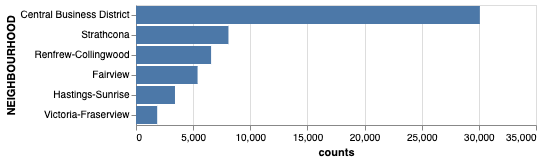

In [10]:
## Crime counts by neighborhood

# Group the data by neighborhood and count the number of crimes in each neighborhood
crime_counts = df.groupby('NEIGHBOURHOOD').size().reset_index(name='counts')

# Create a bar chart showing the crime counts by neighborhood
chart = alt.Chart(crime_counts).mark_bar().encode(
    x='counts',
    y=alt.Y('NEIGHBOURHOOD:N', sort='-x'),
)

chart

In [11]:
# Count of crimes by hundred block, removed first entry as it was null
hundred_block = df.groupby('HUNDRED_BLOCK').size().sort_values(ascending=False)[1:20]
hundred_block

HUNDRED_BLOCK
31XX GRANDVIEW HWY    1960
7XX GRANVILLE ST       860
7XX W GEORGIA ST       846
X NK_LOC ST            718
7XX ROBSON ST          569
1XX WATER ST           390
5XX W HASTINGS ST      360
7XX DUNSMUIR ST        344
3XX ABBOTT ST          340
6XX RICHARDS ST        309
5XX RICHARDS ST        275
8X W PENDER ST         271
1XX W PENDER ST        266
1XX E HASTINGS ST      262
4XX SEYMOUR ST         244
9XX ROBSON ST          239
9XX TERMINAL AVE       236
5XX W BROADWAY AVE     234
5XX HORNBY ST          234
dtype: int64

/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/data.py:226: AltairDeprecationWarning: alt.pipe() is deprecated, and will be removed in a future release. Use toolz.curried.pipe() instead.
  warnings.warn(
/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


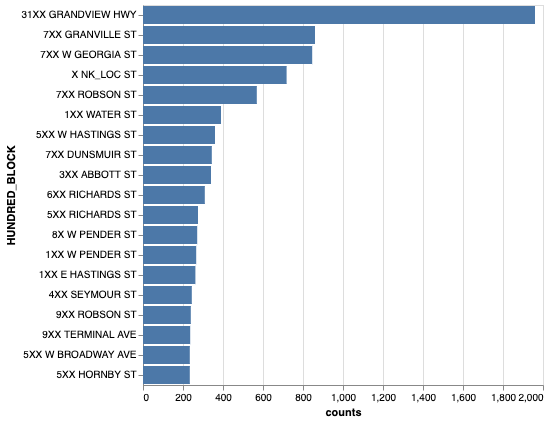

In [12]:
crime_count = df.groupby('HUNDRED_BLOCK').size().sort_values(ascending=False).reset_index(name='counts')[1:20]

alt.Chart(crime_count).mark_bar().encode(
    alt.X('counts'),
    alt.Y('HUNDRED_BLOCK:N', sort='-x')
)

**Crime Type**

In [13]:
# Total number of rows
print("Total number of rows:", len(df))

# Unique values in TYPE column
print("Unique crime types:", df['TYPE'].nunique())
print(df['TYPE'].unique())

Total number of rows: 55398
Unique crime types: 11
['Theft from Vehicle' 'Theft of Bicycle' 'Theft of Vehicle'
 'Vehicle Collision or Pedestrian Struck (with Fatality)'
 'Vehicle Collision or Pedestrian Struck (with Injury)'
 'Break and Enter Commercial' 'Break and Enter Residential/Other'
 'Homicide' 'Mischief' 'Offence Against a Person' 'Other Theft']


/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/data.py:226: AltairDeprecationWarning: alt.pipe() is deprecated, and will be removed in a future release. Use toolz.curried.pipe() instead.
  warnings.warn(
/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


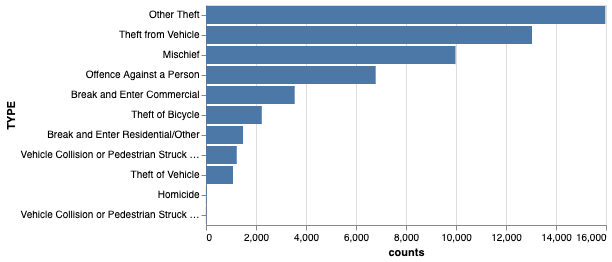

In [14]:
## Crime counts by type

# Group the data by neighborhood and count the number of crimes in each neighborhood
crime_counts = df.groupby('TYPE').size().reset_index(name='counts')

# Create a bar chart showing the crime counts by neighborhood
alt.Chart(crime_counts).mark_bar().encode(
    x='counts',
    y=alt.Y('TYPE:N', sort='-x'),
)

**Time and Date**

/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/data.py:226: AltairDeprecationWarning: alt.pipe() is deprecated, and will be removed in a future release. Use toolz.curried.pipe() instead.
  warnings.warn(
/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


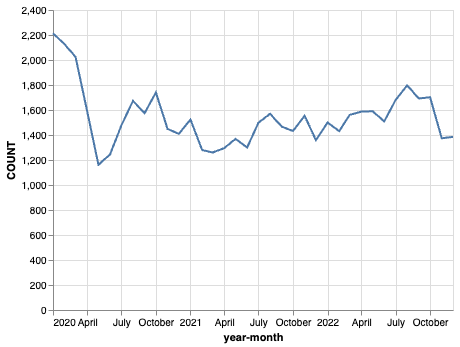

In [15]:
## Crime trends over time

# Create a new column 'year-month' by combining the YEAR and MONTH columns
df['year-month'] = pd.to_datetime(df[['YEAR', 'MONTH']].assign(DAY=1))

# Create a dataframe of crime counts by year-month
month_counts = df.groupby('year-month')['TYPE'].count().reset_index(name='COUNT')

# Create a line chart of crime counts by year-month
alt.Chart(month_counts).mark_line().encode(
    x='year-month:T',
    y='COUNT:Q'
)

In [16]:
# Count of crimes by year
print(df.groupby('YEAR').size().sort_values(ascending=False))

# Number of crimes in 2016
print("Number of crimes in 2016:", len(df[df['YEAR'] == 2016]))

YEAR
2020    19683
2022    18807
2021    16908
dtype: int64
Number of crimes in 2016: 0


In [17]:
# Count of crimes by hour
print(df.groupby('HOUR').size().sort_values(ascending=False))

# Most frequent hour for crimes
print("Most frequent hour for crimes:", df['HOUR'].mode().values[0])

HOUR
0     9643
18    2993
17    2982
16    2710
12    2665
19    2640
15    2544
20    2495
14    2414
22    2271
13    2209
21    2166
11    2003
10    1943
23    1883
9     1809
8     1633
1     1447
7     1275
2     1239
3     1171
4     1138
5     1078
6     1047
dtype: int64
Most frequent hour for crimes: 0


/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/data.py:226: AltairDeprecationWarning: alt.pipe() is deprecated, and will be removed in a future release. Use toolz.curried.pipe() instead.
  warnings.warn(
/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


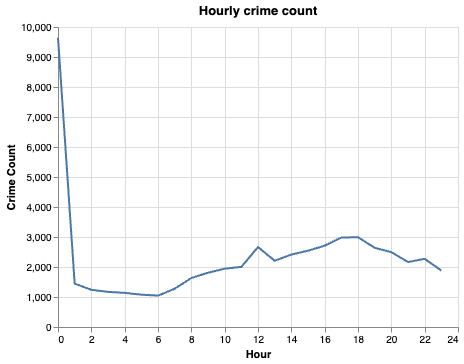

In [18]:
# Hourly Crime Rate

hourly_count = df.groupby('HOUR')['HOUR'].count().reset_index(name='count')

alt.Chart(hourly_count).mark_line().encode(
    x=alt.X('HOUR', title='Hour'),
    y=alt.Y('count', title='Crime Count')
).properties(title='Hourly crime count')

/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/data.py:226: AltairDeprecationWarning: alt.pipe() is deprecated, and will be removed in a future release. Use toolz.curried.pipe() instead.
  warnings.warn(
/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


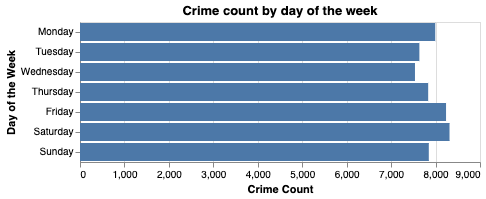

In [19]:
# Crime count by day of the week
df['WEEKDAY'] = df.apply(lambda x: calendar.day_name[datetime.date(x['YEAR'], x['MONTH'], x['DAY']).weekday()], axis=1)

weekday_count = df.groupby('WEEKDAY')['WEEKDAY'].count().reset_index(name='count')
alt.Chart(weekday_count).mark_bar().encode(
    x=alt.X('count', title='Crime Count'),
    y=alt.Y('WEEKDAY', sort=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], title='Day of the Week')
).properties(title='Crime count by day of the week')


### Bivariate Summaries

Secondly, we include bivariate summaries and visuals such as stacked bar charts and layered bar charts.


**Average and Median Income by Neighbourhood**

In [20]:
dfinc.describe().applymap('{:,.2f}'.format)

,Average Household Income After Taxes,Median Household Income After Taxes
count,6.00,6.00
mean,"63,320.78","50,195.42"
std,"11,316.85","13,920.67"
min,"40,925.00","22,542.00"
25%,"65,813.00","53,150.25"
50%,"66,593.50","53,368.50"
75%,"66,889.25","56,540.62"
max,"73,272.00","61,218.00"


/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/data.py:226: AltairDeprecationWarning: alt.pipe() is deprecated, and will be removed in a future release. Use toolz.curried.pipe() instead.
  warnings.warn(
/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


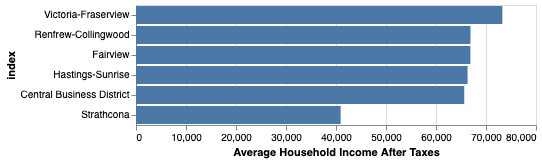

In [21]:
dfinc2 = dfinc.reset_index()

y = alt.Chart(dfinc2).mark_bar(opacity=1).encode(
    x='Average Household Income After Taxes',
    y=alt.Y('index', sort='-x')
)

y

**Crime Type by Neighbourhood**

In [22]:
pd.crosstab(index=df['NEIGHBOURHOOD'], columns = df['TYPE'])

TYPE,Break and Enter Commercial,Break and Enter Residential/Other,Homicide,Mischief,Offence Against a Person,Other Theft,Theft from Vehicle,Theft of Bicycle,Theft of Vehicle,Vehicle Collision or Pedestrian Struck (with Fatality),Vehicle Collision or Pedestrian Struck (with Injury)
NEIGHBOURHOOD,,,,,,,,,,,
Central Business District,2108,365,15,5956,3902,8697,7242,1066,275,7,453
Fairview,573,195,0,747,292,1402,1303,639,111,1,124
Hastings-Sunrise,163,269,3,636,297,542,1098,93,158,1,151
Renfrew-Collingwood,177,250,1,682,414,3143,1334,149,207,2,211
Strathcona,464,292,8,1680,1721,1789,1482,236,235,8,175
Victoria-Fraserview,62,111,2,279,161,399,581,48,94,1,116


/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/data.py:226: AltairDeprecationWarning: alt.pipe() is deprecated, and will be removed in a future release. Use toolz.curried.pipe() instead.
  warnings.warn(
/Users/justin/miniforge3/lib/python3.10/site-packages/altair/utils/core.py:283: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


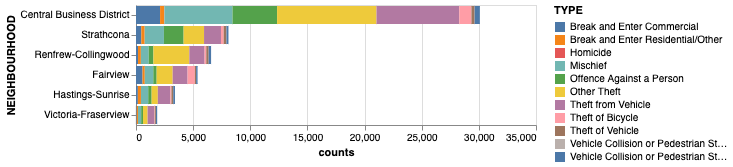

In [23]:
## Crime types by neighborhood

# Group the data by neighborhood and crime type, and count the number of crimes in each category
crime_types = df.groupby(['NEIGHBOURHOOD', 'TYPE']).size().reset_index(name='counts')

# Create a stacked bar chart showing the crime types by neighborhood
x = alt.Chart(crime_types).mark_bar().encode(
    x='counts',
    y=alt.Y('NEIGHBOURHOOD:N', sort='-x'),
    color='TYPE:N'
)
x

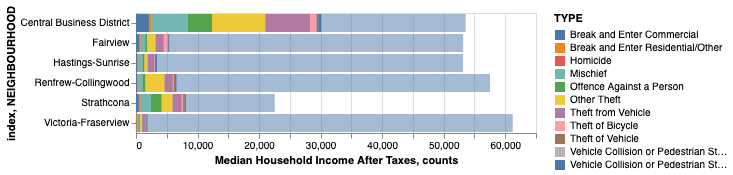

In [24]:
## Crime types by neighborhood + median income
y = alt.Chart(dfinc2).mark_bar(opacity=0.5).encode(
    x='Median Household Income After Taxes',
    y=alt.Y('index', sort='-x')
)

y


# Create a stacked bar chart showing the crime types by neighborhood
alt.layer(y, x)